# Gaussian process Coursework

### Acknowledgements

This notebook owes a lot to the excellent resources made available by [gpflow](https://github.com/GPflow/GPflow), in addition to the [original assignment document](http://mlg.eng.cam.ac.uk/teaching/4f13/1920/cw/coursework1.pdf) by Carl Rasmussen, and Damon Wischik's other [Python version](https://github.com/damonjw/probml). Many parts of it are directly copied from one or other of these resources to avoid re-inventing the wheel.

Additionally, thanks to Marton Havasi and Siddharth Swaroop for their feedback.

### Helpful Resources

- The [GPflow documentation](https://gpflow.readthedocs.io/en/master/?badge=master) is presumably something you will need to consult extensively for this assignment. Likely of particular interest is the documentation on [kernels](https://gpflow.readthedocs.io/en/master/kernel_options.html), [vanilla GP regression](https://gpflow.readthedocs.io/en/master/model_options.html#gp-regression), [the vanilla GP regression notebook](https://nbviewer.jupyter.org/github/GPflow/GPflow/blob/develop/doc/source/notebooks/basics/regression.ipynb) (bits of which I consulted / copied when writing this assignment)
- I would highly recommend both David Mackay's [video lecture](http://videolectures.net/gpip06_mackay_gpb/) on Gaussian processes and the first chunk of Rich's [video lecture](https://www.youtube.com/watch?v=92-98SYOdlY) if you don't feel this GP stuff has clicked yet.
- Carl Rasmussen's [Gaussian Processes for Machine Learning textbook](http://gaussianprocess.org/gpml/) remains the go-to textbook on the basics. Note that it was published in 2006, so necessarily doesn't cover more recent advances.
- Also helpful is David Duvenaud's [kernel cookbook](https://www.cs.toronto.edu/~duvenaud/cookbook/index.html) if you want to understand some more about the properties of different kernels.

### Saving

To save your work between sessions, we recommend that you either

- store and run the notebook locally, and save in the usual manner
- if running remotely using binder, copy + paste your solutions and save them locally, as your state won't be stored between sessions. None of the tasks in this assignment should take more than a few seconds to run, so this approach should be reasonable.

## Setup

Don't worry too much about this section, it should just run, and load the data `x` and `y` the questions below.

Configure your environment.

In [1]:
import gpflow
import gpflow.kernels as kernels
import numpy as np
import matplotlib

# Filter out annoying deprecation / future warnings.
import warnings
warnings.filterwarnings('ignore')


# The lines below are specific to the notebook format
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12, 6)
plt = matplotlib.pyplot

/home/wct23/lib/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/wct23/lib/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/wct23/lib/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/wct23/lib/anaconda3/lib/python3.6/site-packages/tensorflow/python/f

Load the data for the assignment into variables `x` and `y`.

In [21]:
import scipy.io
import io
import requests


# To import a .mat file from a URL:
r = requests.get('http://mlg.eng.cam.ac.uk/teaching/4f13/1920/cw/cw1a.mat')
with io.BytesIO(r.content) as f:
    data = scipy.io.loadmat(f)
    x, y = data['x'], data['y']
print(x.shape)
print(y.shape)

(75, 1)
(75, 1)


## a)

Train a GP on `y` at inputs `x` (loaded above) with a `kernels.SquaredExponential` covariance function, with initial parameters `lengthscales=0.35`, `variance=1.0`, and likelihood variance `1.0`, by minimizing the negative log marginal likelihood starting at this point. Show the 95% predictive error bars and draw some samples from the posterior. Comment on the predictive error bars and the optimized hyperparameters.

(Hint: the GP regression notebook mentioned above will be helpful here, particularly when plotting the results)

In [22]:
# Construct model. The default observation variance is 1.0
k = gpflow.kernels.SquaredExponential(1, lengthscales=0.35, variance=1.0)
model = gpflow.models.GPR(x, y, kern=k, mean_function=None)

In [23]:
# Train model
opt = gpflow.train.ScipyOptimizer()
opt.minimize(model)

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 11.899004
  Number of iterations: 17
  Number of functions evaluations: 28


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 11.899004
  Number of iterations: 17
  Number of functions evaluations: 28


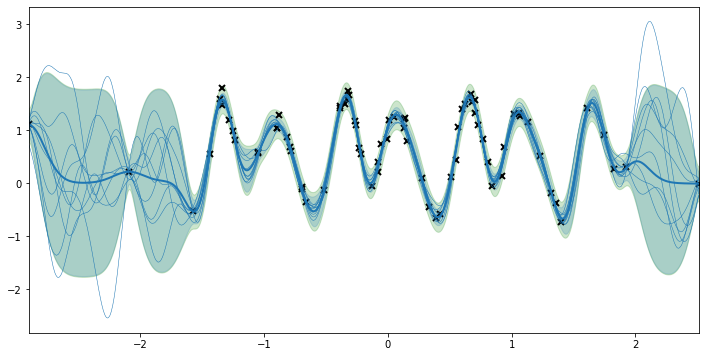

In [24]:
# Generate test points for prediction
xmin, xmax, Npr = np.min(x), np.max(x), 1000
xx = np.linspace(xmin, xmax, Npr).reshape(Npr, 1)  # test points must be of shape (N, D)

# Predict mean and variance of latent GP at test points
mean, var = model.predict_f(xx)

# Predict mean and variance of the latent process + independent noise.
mean_y, var_y = model.predict_y(xx)

# Generate 10 samples from posterior
samples = model.predict_f_samples(xx, 10)  # shape (10, 100, 1)

# Plot 
plt.figure(figsize=(12, 6))
plt.plot(x, y, 'kx', mew=2)
plt.plot(xx, mean, 'C0', lw=2)
plt.fill_between(
    xx[:,0],
    mean[:,0] - 1.96 * np.sqrt(var_y[:,0]),
    mean[:,0] + 1.96 * np.sqrt(var_y[:,0]),
    color='green',
    alpha=0.2,
)
plt.fill_between(
    xx[:,0],
    mean[:,0] - 1.96 * np.sqrt(var[:,0]),
    mean[:,0] + 1.96 * np.sqrt(var[:,0]),
    color='C0',
    alpha=0.2,
)
plt.plot(xx, samples[:, :, 0].T, 'C0', linewidth=.5)
plt.xlim(xmin, xmax);


In [25]:
print(model.compute_log_likelihood())
model.as_pandas_table()

-11.89900424658748


,class,prior,transform,trainable,shape,fixed_shape,value
GPR/kern/lengthscales,Parameter,None,+ve,True,(),True,0.12822639168201727
GPR/kern/variance,Parameter,None,+ve,True,(),True,0.8045928136084768
GPR/likelihood/variance,Parameter,None,+ve,True,(),True,0.013883412757683906


#### Possible answer:

- Error bars larger away from data
- The variance of the noise (likelihood/variance) is small in comparison to that of the Squared Exponential kernel (kern/variance), indicating that the latent Squared Exponential kernel explains most of the signal.
- The lengthscale corresponds to roughly one 'wiggle' in the data
- Only one or two points that don't lie within the shaded region (95% central credible interval)

What value / extra information do posterior samples provide in addition to the posterior marginals? 
(Hint: try repeating the exercise with `kernels.Exponential`)

#### Possible answer:

Samples from a GP look very different from, for example, the posterior mean. While the posterior mean of a GP with a Squared Exponential kernel looks similar to posterior samples (they're all smooth, for example), the posterior mean and posterior samples of a GP with the exponential kernel are quite distinct. As such, while the posterior mean + error bars is informative, it can provide a somewhat misleading summary of the data.

Moreover, say that the x and y axes above correspond to time in (relative) years and temperature respectively, and that we wish to estimate the time at which the maximum temperature occurs in the 0th year. 

The distribution over this quantity can be estimated by generating a large number of posterior samples at some fine-grained grid of points, computing the x value of the maximum for each posterior sample, and plotting this distribution. Clearly, this distribution cannot be obtained by simply examining, for example, the posterior mean.

## b)

Show that by initializing the hyperparameters differently, you can find a different local optimum for
the hyperparameters. Try a range of values. Show the fit. Explain what the model is doing. Which
fit is best, and why? How confident are you about this and why?

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 78.220188
  Number of iterations: 15
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 78.220188
  Number of iterations: 15
  Number of functions evaluations: 20


                             class prior transform  trainable shape  \
GPR/kern/lengthscales    Parameter  None       +ve       True    ()   
GPR/kern/variance        Parameter  None       +ve       True    ()   
GPR/likelihood/variance  Parameter  None       +ve       True    ()   

                         fixed_shape                value  
GPR/kern/lengthscales           True    8.043407662255495  
GPR/kern/variance               True   0.4843935746092187  
GPR/likelihood/variance         True  0.43966337142069023  


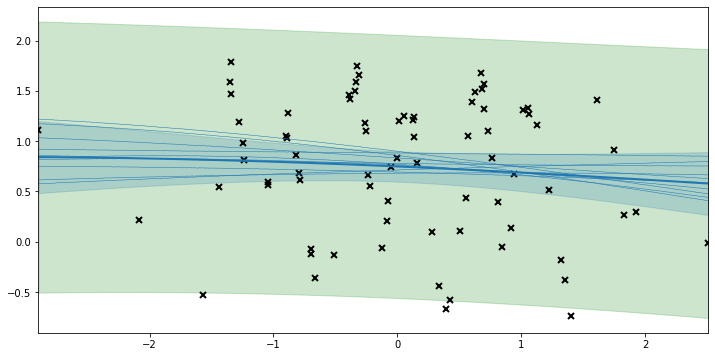

In [26]:
k = gpflow.kernels.SquaredExponential(1, lengthscales=10.0, variance=1.0)
model = gpflow.models.GPR(x, y, kern=k, mean_function=None)
opt = gpflow.train.ScipyOptimizer()
opt.minimize(model)

print(model.as_pandas_table())

# Generate test points for prediction
xmin, xmax, Npr = np.min(x), np.max(x), 1000
xx = np.linspace(xmin, xmax, Npr).reshape(Npr, 1)  # test points must be of shape (N, D)

# Predict mean and variance of latent GP at test points
mean, var = model.predict_f(xx)

mean_y, var_y = model.predict_y(xx)

# Generate 10 samples from posterior
samples = model.predict_f_samples(xx, 10)  # shape (10, 100, 1)

# Plot 
plt.figure(figsize=(12, 6))
plt.fill_between(
    xx[:,0],
    mean[:,0] - 1.96 * np.sqrt(var_y[:,0]),
    mean[:,0] + 1.96 * np.sqrt(var_y[:,0]),
    color='green',
    alpha=0.2,
)
plt.plot(x, y, 'kx', mew=2)
plt.plot(xx, mean, 'C0', lw=2)
plt.fill_between(
    xx[:,0],
    mean[:,0] - 1.96 * np.sqrt(var[:,0]),
    mean[:,0] + 1.96 * np.sqrt(var[:,0]),
    color='C0',
    alpha=0.2,
)
plt.plot(xx, samples[:, :, 0].T, 'C0', linewidth=.5)
plt.xlim(xmin, xmax);


#### Possible Answer:

Initialising with a longer lengthscale causes the optimiser to fall into a different local optimum of the negative log marginal likelihood (NLML), in which the model explains a greater proportion of the signal via i.i.d. additive noise (green error bars). This can be seen via the visualisation of the posterior, but can also simply be read off from the model's `GPR/kern/variance` and `GPR/likelihood/variance` hyperparameters.

As regards whether or not the model provides a better fit: the nlml is lower for the first set of hyperparameters than the one's we obtained here, suggesting that the former model is better. As regards the estimation of interesting quantities, I invite you to think about which model is likely to more accurately estimate the distribution over the location of maximum temperature, as in the previous section.

## c)

Train instead a GP with a periodic covariance function. Show the fit. Comment on the behaviour
of the error-bars, compared to your fit from a). Do you think the data generating mechanism (apart
from the noise) was really strictly periodic? How confident are you about this, and why? Explain
your reasoning.

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -35.266945
  Number of iterations: 43
  Number of functions evaluations: 77


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -35.266945
  Number of iterations: 43
  Number of functions evaluations: 77


                             class prior transform  trainable shape  \
GPR/kern/lengthscales    Parameter  None       +ve       True    ()   
GPR/kern/period          Parameter  None       +ve       True    ()   
GPR/kern/variance        Parameter  None       +ve       True    ()   
GPR/likelihood/variance  Parameter  None       +ve       True    ()   

                         fixed_shape                 value  
GPR/kern/lengthscales           True    0.5154926287589936  
GPR/kern/period                 True    0.9988473441064601  
GPR/kern/variance               True    1.3556578824771743  
GPR/likelihood/variance         True  0.012068039443864134  


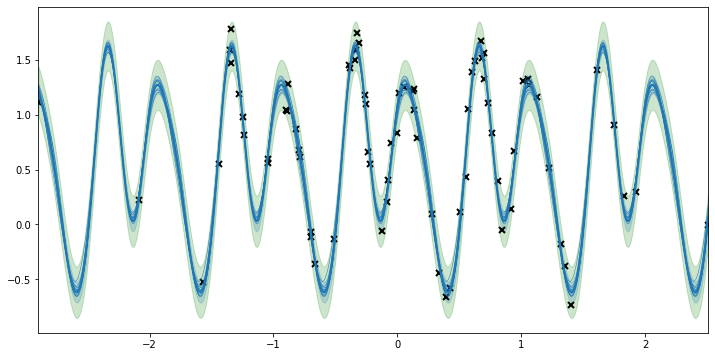

In [8]:
k = gpflow.kernels.Periodic(1, lengthscales=10.0, variance=1.0)
model = gpflow.models.GPR(x, y, kern=k, mean_function=None)
opt = gpflow.train.ScipyOptimizer()
opt.minimize(model)

print(model.as_pandas_table())

# Generate test points for prediction
xmin, xmax, Npr = np.min(x), np.max(x), 1000
xx = np.linspace(xmin, xmax, Npr).reshape(Npr, 1)  # test points must be of shape (N, D)

# Predict mean and variance of latent GP at test points
mean, var = model.predict_f(xx)

mean_y, var_y = model.predict_y(xx)

# Generate 10 samples from posterior
samples = model.predict_f_samples(xx, 10)  # shape (10, 100, 1)

# Plot 
plt.figure(figsize=(12, 6))
plt.fill_between(
    xx[:,0],
    mean[:,0] - 1.96 * np.sqrt(var_y[:,0]),
    mean[:,0] + 1.96 * np.sqrt(var_y[:,0]),
    color='green',
    alpha=0.2,
)
plt.plot(x, y, 'kx', mew=2)
plt.plot(xx, mean, 'C0', lw=2)
plt.fill_between(
    xx[:,0],
    mean[:,0] - 1.96 * np.sqrt(var[:,0]),
    mean[:,0] + 1.96 * np.sqrt(var[:,0]),
    color='C0',
    alpha=0.2,
)
plt.plot(xx, samples[:, :, 0].T, 'C0', linewidth=.5)
plt.xlim(xmin, xmax);

#### Possible answer / more things to think about:

While the data is explained signficantly better by a periodic GP, it's really very hard to say from such a small quantity of data whether or not the data generating mechanism is periodic. Clearly, on the interval `[-2, 2]` it is well-explained by a periodic model, but would you be willing to extrapolate to data on the interval `[8, 10]` using this model? What if the data is only locally periodic, or the phase / amplitude of the periodicity changes across the input space? What extra information would I need to give you / assumptions would you need to make to be confident that this model would extrapolate reliably?

## d)

Generate some random functions evaluated at `x = np.linspace(-5, 5, num=300)` from a GP with the `k_product` covariance function below. Plot some sample functions generated using the `sample_from_prior` function below. Explain the relationship between the properties of those random functions and the form of the covariance function.

In [40]:
k_periodic = kernels.Periodic(1, period=1, variance=0.6, lengthscales=1.0)
k_aperiodic = kernels.SquaredExponential(1, variance=1.0, lengthscales=2.0)
k_product = kernels.Product([k_periodic, k_aperiodic])

In [41]:
def sample_from_prior(kernel, x, n_samples):
    N = x.shape[0]
    K = kernel.compute_K_symm(x) + 1e-12 * np.identity(N)
    L = np.linalg.cholesky(K)
    return L @ np.random.randn(N, n_samples)

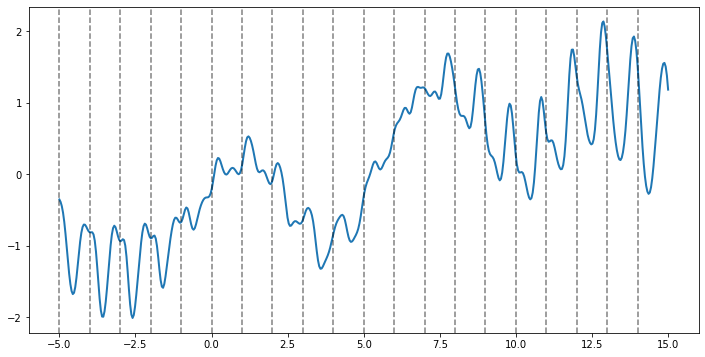

In [42]:
x = np.reshape(np.linspace(-5.0, 15.0, num=500), [500, 1])
Ys = sample_from_prior(k_product, x, 1)
plt.figure(figsize=(12, 6))
plt.plot(x, Ys, 'C0', lw=2)

for x in np.arange(-5.0, step=1.0, stop=15):
    plt.axvline(x=x, color='k', linestyle='--', alpha=0.5)


#### Possible Answer

The samples are locally periodic, and slowly decorrelate slowly over time. Increasing the lengthscale of `k_aperiodic` would increase the time taken for them to decorrelate, while decreasing it would produce a GP whose samples are no longer periodic.

It's important to understand the difference between this kind of model and one in which only the amplitude of the signal changes over time, for example. Notice that the shape of the signal in a given period (as indicated by dashed vertical lines) changes entirely over time. The quasi-periodic kernel might not be an especially appropriate choice for something like temperature, where we at least expect the maximum to occur at a similar time each year. It might, however, make an excellent model for some variable where the location of e.g. the maximum value of the signal within each period meanders around over time, such as as natural sounds.

## e)

Load cw1e.mat. This data has 2-D input and scalar output.

In [12]:
import scipy.io
import io
import requests

r = requests.get('http://mlg.eng.cam.ac.uk/teaching/4f13/1920/cw/cw1e.mat')
with io.BytesIO(r.content) as f:
    data = scipy.io.loadmat(f)
    x_ml, y_ml = data['x'], data['y']

Use the cell below to visualise the data. Rotate it around by changing the arguments to `view_init` and try to get a good feel for it.

(121, 2)
(121, 1)


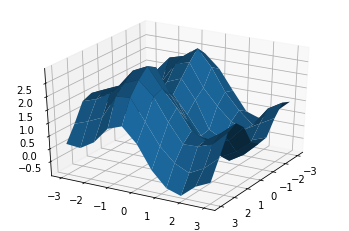

In [13]:
# Make some plotting functionality available.
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.gca(projection='3d')

# Create a surface plot to visualise the data.
ax.view_init(30, 30)
ax.plot_surface(
    np.reshape(x_ml[:, 0], [11, 11]),
    np.reshape(x_ml[:, 1], [11, 11]),
    np.reshape(y_ml, [11, 11]),
)
print(x_ml.shape)
print(y_ml.shape)

Compare two GP models of the data, one with `kernels.SquaredExponential` covariance and the other with a `kernels.Sum` of Squared Exponential covariance functions. For the second model be sure to break symmetry with the initial hyperparameters.
Compare the models: How do the data fits compare? How do the marginal likelihoods compare? Give a careful interpretation of the relationship between data fit, marginal likelihood, and model complexity for these two models.

### Possible answer (isotropic kernels):

In [14]:
k = kernels.SquaredExponential(2, variance=1.0, lengthscales=1)
model = gpflow.models.GPR(x_ml, y_ml, kern=k, mean_function=None)

opt = gpflow.train.ScipyOptimizer()
opt.minimize(model)

print(model.as_pandas_table())

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -18.069069
  Number of iterations: 14
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -18.069069
  Number of iterations: 14
  Number of functions evaluations: 20


                             class prior transform  trainable shape  \
GPR/kern/lengthscales    Parameter  None       +ve       True    ()   
GPR/kern/variance        Parameter  None       +ve       True    ()   
GPR/likelihood/variance  Parameter  None       +ve       True    ()   

                         fixed_shape                 value  
GPR/kern/lengthscales           True    1.4675887880147156  
GPR/kern/variance               True    1.3486761611861913  
GPR/likelihood/variance         True  0.011697574810513811  


In [15]:
k1 = kernels.SquaredExponential(2, variance=1.0, lengthscales=1.0)
k2 = kernels.SquaredExponential(2, variance=1.0, lengthscales=3.0)
k = k1 + k2
model_sum = gpflow.models.GPR(x_ml, y_ml, kern=k, mean_function=None)

opt = gpflow.train.ScipyOptimizer()
opt.minimize(model_sum)

print(model_sum.as_pandas_table())

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -18.435900
  Number of iterations: 68
  Number of functions evaluations: 79


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -18.435900
  Number of iterations: 68
  Number of functions evaluations: 79


                                     class prior transform  trainable shape  \
GPR/kern/kernels/0/lengthscales  Parameter  None       +ve       True    ()   
GPR/kern/kernels/0/variance      Parameter  None       +ve       True    ()   
GPR/kern/kernels/1/lengthscales  Parameter  None       +ve       True    ()   
GPR/kern/kernels/1/variance      Parameter  None       +ve       True    ()   
GPR/likelihood/variance          Parameter  None       +ve       True    ()   

                                 fixed_shape                value  
GPR/kern/kernels/0/lengthscales         True    1.428313979173377  
GPR/kern/kernels/0/variance             True   1.1409434592396956  
GPR/kern/kernels/1/lengthscales         True     9511.15223777175  
GPR/kern/kernels/1/variance             True   0.3165892816416554  
GPR/likelihood/variance                 True  0.01165298358718756  


- Learns one very long length-scale and one short length-scale. The latter represents a constant function.
- Likelihood variance is low, owing to the data being quite noise-free.
- The shorter length-scale in the second example is comparable to the length-scale in the first.
- NLML in second case slightly lower than in the first, suggesting the model is a little better. Hard to know if this is particularly meaningful though.

### Possible answer (ARD kernels):

What happens if each kernel has a different length scale for each input dimension?

In [45]:
k = kernels.SquaredExponential(2, variance=1.0, lengthscales=[1.0, 1.0])
model_sum_similar = gpflow.models.GPR(x_ml, y_ml, kern=k, mean_function=None)

opt = gpflow.train.ScipyOptimizer()
opt.minimize(model_sum_similar)

print(model_sum_similar.as_pandas_table())

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -19.218749
  Number of iterations: 14
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -19.218749
  Number of iterations: 14
  Number of functions evaluations: 20


                             class prior transform  trainable shape  \
GPR/kern/lengthscales    Parameter  None       +ve       True  (2,)   
GPR/kern/variance        Parameter  None       +ve       True    ()   
GPR/likelihood/variance  Parameter  None       +ve       True    ()   

                         fixed_shape                                     value  
GPR/kern/lengthscales           True  [1.5115580463380833, 1.2859391926361243]  
GPR/kern/variance               True                         1.226082346990857  
GPR/likelihood/variance         True                      0.010535175405327094  


In [17]:
k1 = kernels.SquaredExponential(2, variance=1.0, lengthscales=[1.0, 1.0])
k2 = kernels.SquaredExponential(2, variance=1.0, lengthscales=[1.1, 1.1])
k = k1 + k2
model_sum_similar = gpflow.models.GPR(x_ml, y_ml, kern=k, mean_function=None)

opt = gpflow.train.ScipyOptimizer()
opt.minimize(model_sum_similar)

print(model_sum_similar.as_pandas_table())

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -66.408253
  Number of iterations: 75
  Number of functions evaluations: 86


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -66.408253
  Number of iterations: 75
  Number of functions evaluations: 86


                                     class prior transform  trainable shape  \
GPR/kern/kernels/0/lengthscales  Parameter  None       +ve       True  (2,)   
GPR/kern/kernels/0/variance      Parameter  None       +ve       True    ()   
GPR/kern/kernels/1/lengthscales  Parameter  None       +ve       True  (2,)   
GPR/kern/kernels/1/variance      Parameter  None       +ve       True    ()   
GPR/likelihood/variance          Parameter  None       +ve       True    ()   

                                 fixed_shape  \
GPR/kern/kernels/0/lengthscales         True   
GPR/kern/kernels/0/variance             True   
GPR/kern/kernels/1/lengthscales         True   
GPR/kern/kernels/1/variance             True   
GPR/likelihood/variance                 True   

                                                                    value  
GPR/kern/kernels/0/lengthscales  [1.4469254953430855, 113979.02066325203]  
GPR/kern/kernels/0/variance                            1.2314183436013522  
GPR/kern

Each kernel has one long length scale and one short length scale, indicating that each kernel depends on only one diimension of the inputs. The NLML is significantly lower than before, but the likelihood variance (a good proxy for RMSE on the training data) is very similar to before. This indicates that while the model fit has not changed substantially, the complexity penalty (the log det of the covariance matrix) must be substantially smaller than before.

The model has essentially learned an additive structure, whereby the first kernel is only a function of the first dimension, and the second the second dimension, implying that the GP is (roughly speaking) of the form
$f(x_1, x_2) = f_1(x_1) + f_2(x_2)$.

Other questions you might think about:
- Intuitively speaking, why should the complexity penalty of an additive model be lower than a non-additive model? Think about the types of functions you can / can't describe with additive models.
- Is there anything special about the ordering we learned here?
- More parameters -> simpler model in this case.